# Fitted Q Iteration (FQI)

今回はFQIについて解説していきたいと思います．

テーブル形式の強化学習を思い出してみると, 状態空間や行動空間が膨大になった時や連続値になった時に学習が困難になってしまいます．

そこでテーブル形式の代わりに自由度の低い関数近似器を使い, 学習することを関数近似を用いた強化学習と言います．

代表例では**ニューラルネットワーク**がその例ですね．

**FQI**はこの関数近似器の一例です．式は下のように書けます．

$$
Q_w(s,a) := w^T\phi(s,a)
$$

重み$w$の更新式はこちらの[資料](https://users.cs.duke.edu/~parr/setn02.pdf)を参照してください．

### 早速, コードを書いていきます．

#

In [1]:
import jax 

import jax.numpy as jnp
import numpy as np
from typing import NamedTuple,Optional
import matplotlib.pyplot as plt

S = 100 #state_size
A = 10  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array
    phi : np.array
    horizon : int
    

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)
d = 5
phi = np.random.randn(S,A,d)
horizon = int(1 / (1 - gamma))
mdp = MDP(S_array,A_array,gamma,rew,P,phi,horizon)
w = np.random.randn(d)
print(mdp.rew.shape)
print(mdp.P.shape)


(100, 10)
(100, 10, 100)


In [2]:
@jax.jit
def get_greedy(mdp:MDP, q:jnp.array):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    #行列形式の演算も最適作用素で行いたいので，1番価値が高い,行動の列だけを各状態で１にする．
    pi_max = jnp.zeros((S,A))
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)

    return pi_max


@jax.jit
def target_q_get(mdp:MDP, q:np.array):
    S,_ = q.shape
    greedy_policy = get_greedy(mdp,q)
    next_v = np.sum(greedy_policy * q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * next_v, axis=-1)
    return mdp.rew + mdp.gamma * next_v

[14.670348,
 12.648854,
 12.43437,
 12.412291,
 12.410036,
 12.409805,
 12.409781,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.40978,
 12.

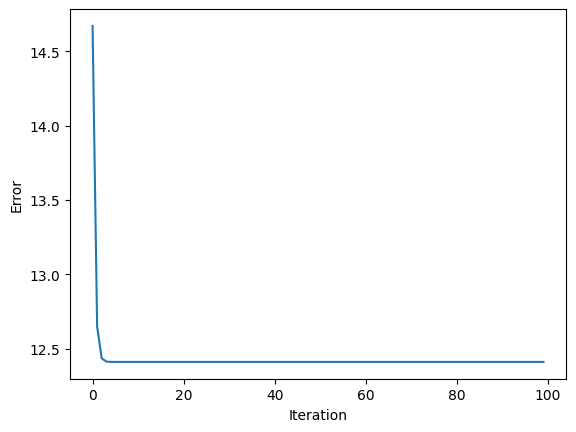

In [4]:
def fitted_q_iteration(mdp: MDP,iteration : int):
    d = mdp.phi.shape[-1]
    w = np.random.randn(d)
    phi = mdp.phi.reshape(S*A, d)
    #Q_featureとPhiを行列演算したらQ関数(shape:S * A)
    Q_error = []

    for _ in range(iteration):
        Q = phi @ w
        target_Q = target_q_get(mdp=mdp,q=Q.reshape(S,A)).reshape(S * A)
        # 重みの更新
        w = np.linalg.inv(phi.T @ phi) @ phi.T @ target_Q
        Q = mdp.phi @ w
        Q_error.append(np.abs(Q - target_Q.reshape(100,10)).max())

    plt.plot(Q_error)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    return Q_error

fitted_q_iteration(mdp,100)